# Topic Modeling

Read more about the theory and the syntax in these [two](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) [blogposts](https://medium.com/@pratikbarhate/latent-dirichlet-allocation-for-beginners-a-high-level-intuition-23f8a5cbad71).

In [0]:
import re
import time
import nltk
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /Users/celsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/celsa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/celsa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
def visualize_wordcloud_dict_frequencies(dict_freqs, title, relative_scaling=0.5, max_words=100,
                                background_color='black'):
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(width=900, height=500, max_words=max_words, relative_scaling=relative_scaling,
                          normalize_plurals=False, background_color=background_color).generate_from_frequencies(
        dict_freqs)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Load raw reviews and extract sample

In [0]:
data = pd.read_csv('Reviews.csv')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


#### Work only with data older than 2010

In [0]:
data['year'] = pd.to_datetime(data['Time'],unit='s').dt.year
recient_dat = data[data['year']>2010]
sample = recient_dat.iloc[:10000]

## TF-IDF Vectorization of sample reviews

In [0]:
# Initialise the TF-IDF vectorizer with a given min_document_frequency and max_document_frequency
vectorizer = TfidfVectorizer(max_df=1000, min_df=100)

# Transform the data into normalized frequencies of words
X_tfidf = vectorizer.fit_transform(sample['Text'])

# Build the column names dictionary -> ordered dataframe
tfidf_dict = vectorizer.vocabulary_
df_tf_idf_voc = pd.DataFrame({'column_name': list(tfidf_dict.keys()), 'column_index': list(tfidf_dict.values())})
df_tf_idf_voc = df_tf_idf_voc.sort_values(by='column_index')

# Build the matrix dataframe with the right columns
df_X_tfidf = pd.DataFrame(X_tfidf.toarray())
df_X_tfidf.columns = df_tf_idf_voc['column_name'].tolist()

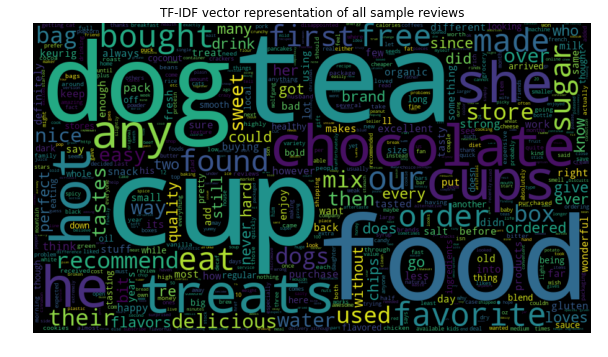

In [0]:
title="TF-IDF vector representation of all sample reviews"
d_freq_tfidf = df_X_tfidf.sum().to_dict()
visualize_wordcloud_dict_frequencies(d_freq_tfidf, title, relative_scaling=0.5, max_words=1000,
                                background_color='black')

## Latent Dirichlet Allocation (LDA)

In [0]:
# Tweak the two parameters below
number_topics = 3
batch_size = 1000
doc_topic_prior = 0.7#1/number_topics
topic_word_prior = 0.5#1/number_topics

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, 
                                doc_topic_prior=doc_topic_prior,
                                topic_word_prior=topic_word_prior,
                                batch_size=batch_size)
lda.fit(X_tfidf)

# Extract word distributions for the optimized topics from LDA model
topic0 = lda.components_[0]
topic1 = lda.components_[1]
topic2 = lda.components_[2]
words = vectorizer.get_feature_names()

In [0]:
lda.get_params

<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=1000, doc_topic_prior=0.7,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.5,
             total_samples=1000000.0, verbose=0)>

In [0]:
dict(zip(words, topic0))

{'10': 26.93528071895436,
 '100': 2.595837869720838,
 '12': 8.312793853964482,
 '15': 5.843807856673157,
 '16': 1.2781003028630797,
 '20': 6.0019970195878205,
 '24': 8.590039648223087,
 '25': 8.962643241438023,
 '30': 1.7614686080891235,
 '50': 7.792670033432568,
 'able': 39.2541701907837,
 'absolutely': 6.573536426405953,
 'actually': 43.827143948487915,
 'add': 53.9182506152295,
 'added': 26.857863504373025,
 'adding': 13.074515850669476,
 'addition': 3.2828164764816403,
 'aftertaste': 23.76075804374074,
 'ago': 26.409838713631913,
 'almost': 25.050559252694697,
 'along': 6.589380362864712,
 'already': 21.399906410495255,
 'alternative': 9.161467422633002,
 'although': 15.145055213361504,
 'always': 32.872603141737194,
 'amazing': 17.72652741398023,
 'amount': 28.836761403073474,
 'another': 28.432870171973814,
 'any': 44.542989422705354,
 'anyone': 19.37584482825207,
 'anything': 13.478394447622732,
 'anyway': 14.75999724708409,
 'anywhere': 4.033180976987817,
 'aren': 1.62123426146

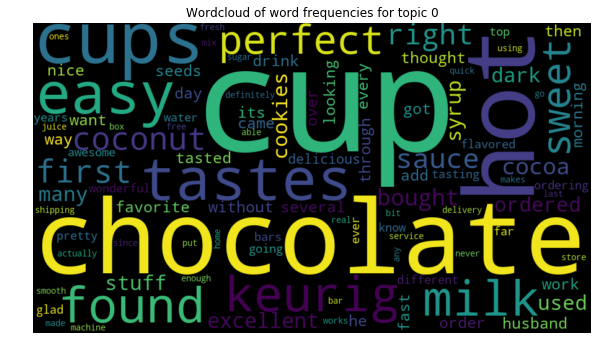

In [0]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic0 = dict(zip(words, topic0))
title="Wordcloud of word frequencies for topic 0"
visualize_wordcloud_dict_frequencies(d_topic0, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

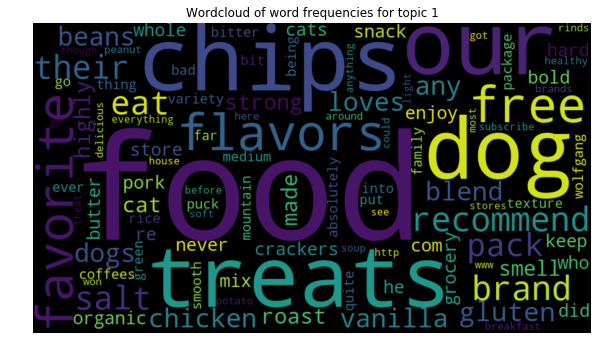

In [0]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic1 = dict(zip(words, topic1))
title="Wordcloud of word frequencies for topic 1"
visualize_wordcloud_dict_frequencies(d_topic1, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

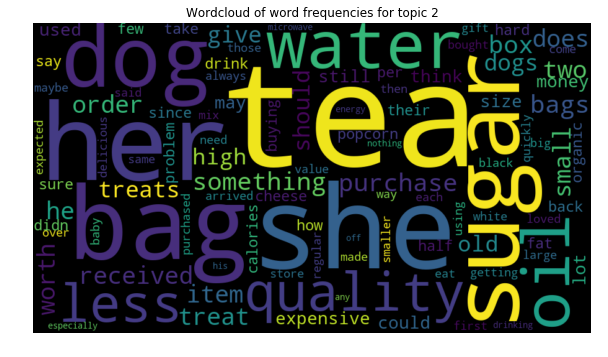

In [0]:
# Create a dictionary between the words and the frequencies for the given topic
d_topic2 = dict(zip(words, topic2))
title="Wordcloud of word frequencies for topic 2"
visualize_wordcloud_dict_frequencies(d_topic2, title, relative_scaling=0.5, max_words=100,
                                background_color='black')